### Установка архива

In [8]:
!wget https://sochi-hub.obs.ru-moscow-1.hc.sbercloud.ru:443/wildlife_project/whale_leus/Whale%20ReId%202.7z

--2025-06-02 15:38:02--  https://sochi-hub.obs.ru-moscow-1.hc.sbercloud.ru/wildlife_project/whale_leus/Whale%20ReId%202.7z
Resolving sochi-hub.obs.ru-moscow-1.hc.sbercloud.ru (sochi-hub.obs.ru-moscow-1.hc.sbercloud.ru)... 46.243.206.34, 46.243.206.35
Connecting to sochi-hub.obs.ru-moscow-1.hc.sbercloud.ru (sochi-hub.obs.ru-moscow-1.hc.sbercloud.ru)|46.243.206.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7624464497 (7.1G) [application/x-7z-compressed]
Saving to: ‘Whale ReId 2.7z’

Whale ReId 2.7z     100%[===================>]   7.10G  8.10MB/s    in 15m 21s 

2025-06-02 15:53:25 (7.89 MB/s) - ‘Whale ReId 2.7z’ saved [7624464497/7624464497]



In [9]:
!pip install py7zr

In [10]:
import py7zr
import os

with py7zr.SevenZipFile('/content/Whale ReId 2.7z', mode='r') as archive:
    all_files = archive.getnames()

In [11]:
archive_path = "/content/Whale ReId 2.7z"
extract_dir = "/content/Whales"

os.makedirs(extract_dir, exist_ok=True)

with py7zr.SevenZipFile(archive_path, mode='r') as archive:
    archive.extractall(path=extract_dir)

In [ ]:
!find /content/Whales -type f -name "*.png" -delete

In [ ]:
import shutil
from tqdm import tqdm
import random

def split_whale_data(source_dir, train_ratio=0.8):
    whales = os.listdir(source_dir)
    for whale in tqdm(whales):
        whale_path = os.path.join(source_dir, whale)
        dates = os.listdir(whale_path)
        random.shuffle(dates)

        total_photos = sum(
            len(os.listdir(os.path.join(whale_path, date)))
            for date in dates
        )
        target_test_photos = int(total_photos * (1 - train_ratio))

        train_dates, test_dates = [], []
        test_photo_count = 0

        for date in dates:
            date_photos = len(os.listdir(os.path.join(whale_path, date)))
            if test_photo_count + date_photos <= target_test_photos:
                test_dates.append(date)
                test_photo_count += date_photos
            else:
                train_dates.append(date)

        if not test_dates:
            test_dates = [random.choice(dates)]
            train_dates = [d for d in dates if d not in test_dates]

        for date in train_dates:
            src = os.path.join(whale_path, date)
            dst = os.path.join("whales_processed/train", whale, date)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copytree(src, dst)

        for date in test_dates:
            src = os.path.join(whale_path, date)
            dst = os.path.join("whales_processed/test", whale, date)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copytree(src, dst)

split_whale_data("/content/Whales/Whale ReId 2")

In [ ]:
def check_balance(root_dir, min_train_percent=70, max_train_percent=90):
    stats = {}
    deleted_whales = []

    for split in ["train", "test"]:
        split_path = os.path.join(root_dir, split)
        if not os.path.exists(split_path):
            continue

        for whale in os.listdir(split_path):
            if whale not in stats:
                stats[whale] = {"train": {"photos": 0, "dates": 0},
                               "test": {"photos": 0, "dates": 0}}

            whale_path = os.path.join(split_path, whale)
            photo_count = 0
            date_count = 0

            for date in os.listdir(whale_path):
                date_path = os.path.join(whale_path, date)
                if os.path.isdir(date_path):
                    date_count += 1
                    photos = [f for f in os.listdir(date_path)
                             if f.lower().endswith(('.jpg'))]
                    photo_count += len(photos)

            stats[whale][split]["photos"] = photo_count
            stats[whale][split]["dates"] = date_count

    for whale, data in stats.copy().items():
        total_photos = data["train"]["photos"] + data["test"]["photos"]
        total_dates = data["train"]["dates"] + data["test"]["dates"]

        if total_photos == 0 or total_dates <= 2:
            for split in ["train", "test"]:
                whale_path = os.path.join(root_dir, split, whale)
                if os.path.exists(whale_path):
                    shutil.rmtree(whale_path)

            deleted_whales.append(whale)
            del stats[whale]
            continue

        train_percent = (data["train"]["photos"] / total_photos) * 100

        if not (min_train_percent <= train_percent <= max_train_percent):
            for split in ["train", "test"]:
                whale_path = os.path.join(root_dir, split, whale)
                if os.path.exists(whale_path):
                    shutil.rmtree(whale_path)

            deleted_whales.append(whale)
            del stats[whale]

    # Вывод статистики
    print("\n{:<15} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
        "Кит", "Train фото", "Test фото", "Train %", "Test %", "Даты (train/test)"))
    print("-" * 70)

    for whale, data in stats.items():
        total = data["train"]["photos"] + data["test"]["photos"]
        train_p = (data["train"]["photos"] / total) * 100
        test_p = (data["test"]["photos"] / total) * 100

        print("{:<15} {:<10} {:<10} {:<10.1f}% {:<10.1f}% {:<10}".format(
            whale,
            data["train"]["photos"],
            data["test"]["photos"],
            train_p,
            test_p,
            f"{data['train']['dates']}/{data['test']['dates']}"
        ))

    # Вывод удаленных папок
    if deleted_whales:
        print("\nУдаленные папки с плохим балансом или малым числом дат:")
        for whale in deleted_whales:
            print(f"- {whale}")
    else:
        print("\nВсе папки соответствуют критериям!")

# Пример использования
check_balance("whales_processed", min_train_percent=70, max_train_percent=90)

In [ ]:
def flatten_directory_structure(root_dir):
    for split in ["train", "test"]:
        split_path = os.path.join(root_dir, split)
        if not os.path.exists(split_path):
            continue

        for whale in tqdm(os.listdir(split_path), desc=f"Processing {split}"):
            whale_path = os.path.join(split_path, whale)

            for root, dirs, files in os.walk(whale_path):
                for file in files:
                    if file.lower().endswith(('.jpg')):
                        src_path = os.path.join(root, file)

                        date_folder = os.path.basename(root)
                        new_filename = f"{date_folder}_{file}"

                        dest_path = os.path.join(whale_path, new_filename)

                        shutil.move(src_path, dest_path)

            for root, dirs, files in os.walk(whale_path, topdown=False):
                for dir in dirs:
                    dir_path = os.path.join(root, dir)
                    if not os.listdir(dir_path):
                        os.rmdir(dir_path)

flatten_directory_structure("whales_processed")

In [ ]:
import shutil
from tqdm import tqdm
import random

def keep_common_folders(dataset_path, max_folders_to_keep=8):
    """Оставляет только указанное количество общих папок в train/test"""
    train_path = os.path.join(dataset_path, "train")
    test_path = os.path.join(dataset_path, "test")

    train_folders = set(os.listdir(train_path)) if os.path.exists(train_path) else set()
    test_folders = set(os.listdir(test_path)) if os.path.exists(test_path) else set()

    common_folders = list(train_folders & test_folders)
    print(f"Найдено общих папок: {len(common_folders)}")

    if len(common_folders) < max_folders_to_keep:
        print(f"Внимание: доступно только {len(common_folders)} общих папок")
        max_folders_to_keep = len(common_folders)

    folders_to_keep = random.sample(common_folders, max_folders_to_keep)
    print(f"Сохраняем папки: {', '.join(folders_to_keep)}")

    if os.path.exists(train_path):
        for folder in tqdm(os.listdir(train_path), desc="Обработка train"):
            if folder not in folders_to_keep:
                shutil.rmtree(os.path.join(train_path, folder))
    if os.path.exists(test_path):
        for folder in tqdm(os.listdir(test_path), desc="Обработка test"):
            if folder not in folders_to_keep:
                shutil.rmtree(os.path.join(test_path, folder))

dataset_path = "whales_processed"
keep_common_folders(
    dataset_path=dataset_path,
    max_folders_to_keep=30
)

Найдено общих папок: 59
Сохраняем папки: 20_26_frames, 20_55_frames, 20_01_frames, 22_07_frames, 20_42_frames, 20_43_frames, 20_37_frames, 20_56_frames, 20_48_frames, 20_39_frames, 20_21_frames, 21_27_frames, 21_05_frames, 21_34_frames, 20_45_frames, 20_70_frames, 20_02_frames, 20_40_frames, 20_05_frames, 20_04_frames, 21_37_frames, 21_55_frames, 21_09_frames, 21_02_frames, 20_03_frames, 21_06_frames, 21_67_frames, 21_14_frames, 20_14_frames, 21_36_frames


Обработка test: 100%|██████████| 59/59 [00:00<00:00, 1094.58it/s]


### Далее начинается работа с предсказаниями

In [1]:
import os
import faiss
import numpy as np
import torch
import timm
import torchvision.transforms as T
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import precision_score

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_PATH = "whales_processed"
MODEL_NAME = "hf-hub:BVRA/MegaDescriptor-S-224"
IMAGE_SIZE = 224
#384
model = timm.create_model(MODEL_NAME, pretrained=True).to(DEVICE)
model.eval()

transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [ ]:
def get_embedding(image_path):
    """Получение эмбеддинга для одного изображения"""
    img = Image.open(image_path).convert('RGB')
    tensor = transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        features = model(tensor)
    return features.cpu().numpy().flatten()

In [ ]:
def build_faiss_index(folder_path):
    """Построение FAISS индекса"""
    embeddings = []
    paths = []

    for root, _, files in os.walk(folder_path):
        for file in tqdm(files, desc=f"Обработка {os.path.basename(root)}"):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(root, file)
                emb = get_embedding(path)
                if emb is not None:
                    embeddings.append(emb)
                    paths.append(path)

    dimension = embeddings[0].shape[0]
    index = faiss.IndexFlatL2(dimension)
    index.add(np.array(embeddings).astype('float32'))

    return index, paths

In [ ]:
def search_similar(query_path, index, paths, k=5):
    """Поиск похожих изображений"""
    query_emb = get_embedding(query_path)
    if query_emb is None:
        return []

    distances, indices = index.search(np.array([query_emb]).astype('float32'), k)
    return [(paths[i], distances[0][j]) for j, i in enumerate(indices[0])]

In [ ]:
import matplotlib.pyplot as plt

def show_results(query_path, results):
    """Визуализация найденных изображений"""
    plt.figure(figsize=(15,5))

    plt.subplot(1, 6, 1)
    plt.imshow(Image.open(query_path))
    plt.title("Query Image")

    for i, (path, distance) in enumerate(results, 1):
        plt.subplot(1, 6, i+1)
        plt.imshow(Image.open(path))
        plt.title(f"#{i}\n{distance:.2f}")

    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
    classification_report
)
import seaborn as sns

def evaluate_model(test_folder, index, paths, k_values=(1, 5)):
    """Расширенная оценка модели с несколькими метриками"""
    y_true = []
    y_pred = []
    all_scores = {k: [] for k in k_values}

    for root, _, files in os.walk(test_folder):
        for file in tqdm(files, desc="Оценка модели"):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                query_path = os.path.join(root, file)
                true_label = os.path.basename(root)

                results = search_similar(query_path, index, paths, k=max(k_values))
                if not results:
                    continue

                retrieved_labels = [os.path.basename(os.path.dirname(p[0])) for p in results]
                for k in k_values:
                    all_scores[k].append(1 if true_label in retrieved_labels[:k] else 0)

                pred_label = retrieved_labels[0]
                y_true.append(true_label)
                y_pred.append(pred_label)

    print("\nКлассификационные метрики (top-1):")
    print(classification_report(y_true, y_pred, zero_division=0))

    print("\nМетрики поиска:")
    for k in k_values:
        recall_at_k = np.mean(all_scores[k])
        print(f"Recall@{k}: {recall_at_k:.2%}")

    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return {
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'f1': f1_score(y_true, y_pred, average='weighted'),
        'accuracy': accuracy_score(y_true, y_pred),
        'recall@k': {k: np.mean(all_scores[k]) for k in k_values}
    }

In [ ]:
train_index, train_paths = build_faiss_index(os.path.join(DATA_PATH, "train"))

Обработка train: 0it [00:00, ?it/s]

Обработка 20_42_frames:   0%|          | 0/134 [00:00<?, ?it/s]

Обработка 21_55_frames:   0%|          | 0/61 [00:00<?, ?it/s]

Обработка 21_34_frames:   0%|          | 0/312 [00:00<?, ?it/s]

Обработка 21_09_frames:   0%|          | 0/249 [00:00<?, ?it/s]

Обработка 21_02_frames:   0%|          | 0/232 [00:00<?, ?it/s]

Обработка 20_39_frames:   0%|          | 0/323 [00:00<?, ?it/s]

Обработка 20_37_frames:   0%|          | 0/249 [00:00<?, ?it/s]

Обработка 21_27_frames:   0%|          | 0/274 [00:00<?, ?it/s]

Обработка 21_05_frames:   0%|          | 0/133 [00:00<?, ?it/s]

Обработка 20_45_frames:   0%|          | 0/465 [00:00<?, ?it/s]

Обработка 22_07_frames:   0%|          | 0/396 [00:00<?, ?it/s]

Обработка 21_06_frames:   0%|          | 0/53 [00:00<?, ?it/s]

Обработка 20_48_frames:   0%|          | 0/406 [00:00<?, ?it/s]

Обработка 21_37_frames:   0%|          | 0/72 [00:00<?, ?it/s]

Обработка 20_02_frames:   0%|          | 0/133 [00:00<?, ?it/s]

Обработка 20_43_frames:   0%|          | 0/448 [00:00<?, ?it/s]

Обработка 20_70_frames:   0%|          | 0/346 [00:00<?, ?it/s]

Обработка 21_14_frames:   0%|          | 0/123 [00:00<?, ?it/s]

Обработка 20_56_frames:   0%|          | 0/548 [00:00<?, ?it/s]

Обработка 20_21_frames:   0%|          | 0/715 [00:00<?, ?it/s]

Обработка 20_40_frames:   0%|          | 0/591 [00:00<?, ?it/s]

Обработка 20_05_frames:   0%|          | 0/64 [00:00<?, ?it/s]

Обработка 20_26_frames:   0%|          | 0/835 [00:00<?, ?it/s]

Обработка 20_55_frames:   0%|          | 0/859 [00:00<?, ?it/s]

Обработка 20_03_frames:   0%|          | 0/216 [00:00<?, ?it/s]

Обработка 20_14_frames:   0%|          | 0/1098 [00:00<?, ?it/s]

Обработка 21_67_frames:   0%|          | 0/182 [00:00<?, ?it/s]

Обработка 21_36_frames:   0%|          | 0/66 [00:00<?, ?it/s]

Обработка 20_01_frames:   0%|          | 0/333 [00:00<?, ?it/s]

Обработка 20_04_frames:   0%|          | 0/852 [00:00<?, ?it/s]

Оценка модели: 0it [00:00, ?it/s]

Оценка модели:   0%|          | 0/45 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/10 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/58 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/46 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/54 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/73 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/53 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/68 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/31 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/95 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/68 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/9 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/58 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/17 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/24 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/95 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/82 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/25 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/126 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/103 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/142 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/15 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/207 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/213 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/52 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/217 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/44 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/11 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/55 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/155 [00:00<?, ?it/s]


Классификационные метрики (top-1):
              precision    recall  f1-score   support

20_01_frames       0.70      0.47      0.57        55
20_02_frames       0.95      0.79      0.86        24
20_03_frames       0.44      0.94      0.60        52
20_04_frames       0.72      0.80      0.76       155
20_05_frames       0.82      0.93      0.88        15
20_14_frames       0.08      0.07      0.07       217
20_21_frames       0.27      0.08      0.12       103
20_26_frames       0.93      0.52      0.67       207
20_37_frames       0.70      0.89      0.78        53
20_39_frames       0.65      0.23      0.34        73
20_40_frames       0.75      0.93      0.83       142
20_42_frames       0.71      0.76      0.73        45
20_43_frames       0.73      1.00      0.84        95
20_45_frames       0.73      0.79      0.76        95
20_48_frames       0.77      1.00      0.87        58
20_55_frames       0.79      0.77      0.78       213
20_56_frames       0.72      1.00      0.83  

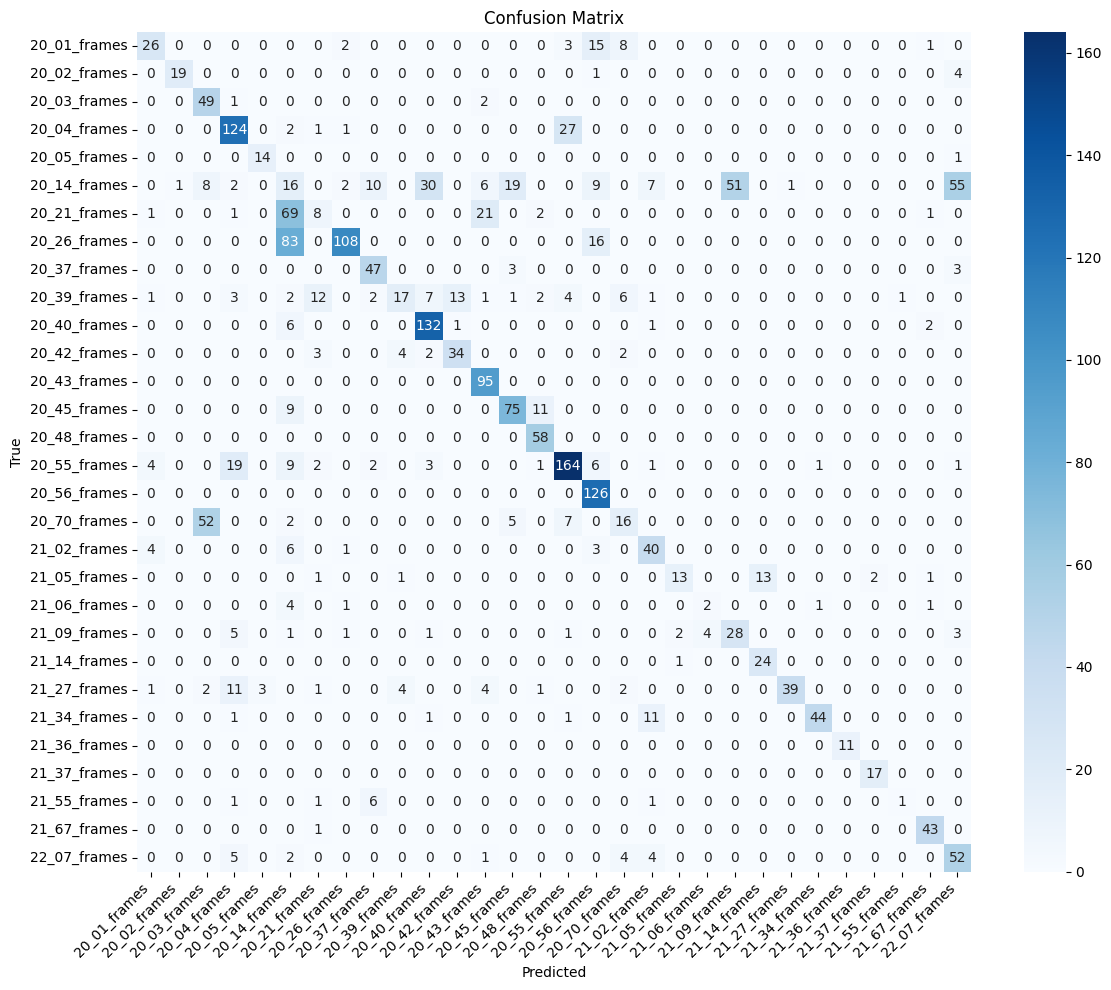

{'precision': 0.6483657136673743, 'recall': 0.6406041759218125, 'f1': 0.6196683407973431, 'accuracy': 0.6406041759218125, 'recall@k': {1: 0.6406041759218125, 3: 0.6974677920924034, 5: 0.7254553531763661, 7: 0.7445579742336739}}


In [ ]:
metrics = evaluate_model(
    test_folder=os.path.join(DATA_PATH, "test"),
    index=train_index,
    paths=train_paths,
    k_values=(1,3,5,7)
)
print(metrics)

### Тестирование для веба

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SOURCE_DIR = "/content/Whales/Whale ReId 2"
OUTPUT_DIR = "whales_processed_all"
MODEL_NAME = "hf-hub:BVRA/MegaDescriptor-S-224"
IMAGE_SIZE = 224
INDEX_FILE = "whales_faiss_index.pkl"

# Загрузка модели
model = timm.create_model(MODEL_NAME, pretrained=True).to(DEVICE)
model.eval()

# Трансформации изображений
transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [ ]:
import pickle

In [ ]:
def apply_mask(img_path, mask_path):
    """Применение маски к изображению"""
    try:
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Конвертируем в grayscale
        return Image.composite(image, Image.new("RGB", image.size, (0, 0, 0)), mask)
    except Exception as e:
        print(f"Error applying mask to {img_path}: {e}")
        return None

def process_all_images_with_masks():
    """Обработка всех изображений с применением масок"""
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Собираем все frame_* директории
    frame_dirs = [d for d in os.listdir(SOURCE_DIR) if d.endswith('_frames')]

    for frame_dir in tqdm(frame_dirs, desc="Processing frame directories"):
        frame_path = os.path.join(SOURCE_DIR, frame_dir)

        # Находим все crop_* директории внутри frame_*
        crop_dirs = [d for d in os.listdir(frame_path) if d.startswith('crop')]

        for crop_dir in crop_dirs:
            crop_path = os.path.join(frame_path, crop_dir)

            # Создаем выходную директорию (используем frame_dir как класс)
            output_class_dir = os.path.join(OUTPUT_DIR, frame_dir)
            os.makedirs(output_class_dir, exist_ok=True)

            # Обрабатываем все jpg/png файлы
            for file in os.listdir(crop_path):
                if file.lower().endswith('.jpg'):
                    # Применяем маску если она существует
                    stem = os.path.splitext(file)[0]
                    img_path = os.path.join(crop_path, file)
                    mask_path = os.path.join(crop_path, f"{stem}.png")

                    if os.path.exists(mask_path):
                        masked_img = apply_mask(img_path, mask_path)
                        if masked_img:
                            output_path = os.path.join(output_class_dir, f"{frame_dir}_{crop_dir}_{file}")
                            masked_img.save(output_path)
                    else:
                        # Если маски нет, просто копируем оригинал
                        img = Image.open(img_path).convert('RGB')
                        output_path = os.path.join(output_class_dir, f"{frame_dir}_{crop_dir}_{file}")
                        img.save(output_path)

process_all_images_with_masks()

Processing frame directories: 100%|██████████| 102/102 [09:34<00:00,  5.63s/it]


In [ ]:
def get_embedding(image_path):
    """Получение эмбеддинга для одного изображения"""
    try:
        img = Image.open(image_path).convert('RGB')
        tensor = transform(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            features = model(tensor)
        return features.cpu().numpy().flatten()
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def build_and_save_index():
    """Построение и сохранение FAISS индекса"""
    embeddings = []
    paths = []
    class_names = []

    # Собираем все классы (frame_* директории)
    classes = sorted([d for d in os.listdir(OUTPUT_DIR) if os.path.isdir(os.path.join(OUTPUT_DIR, d))])
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    idx_to_class = {i: cls_name for i, cls_name in enumerate(classes)}

    # Собираем эмбеддинги для всех изображений
    for cls_name in tqdm(classes, desc="Processing classes"):
        class_path = os.path.join(OUTPUT_DIR, cls_name)

        for file in os.listdir(class_path):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(class_path, file)
                emb = get_embedding(path)
                if emb is not None:
                    embeddings.append(emb)
                    paths.append(path)
                    class_names.append(cls_name)

    # Создаем и сохраняем индекс
    dimension = embeddings[0].shape[0]
    index = faiss.IndexFlatL2(dimension)
    index.add(np.array(embeddings).astype('float32'))

    # Сохраняем все данные в один файл
    data_to_save = {
        'index': index,
        'paths': paths,
        'class_names': class_names,
        'class_to_idx': class_to_idx,
        'idx_to_class': idx_to_class,
        'transform': transform,
        'model_name': MODEL_NAME,
        'image_size': IMAGE_SIZE
    }

    with open(INDEX_FILE, 'wb') as f:
        pickle.dump(data_to_save, f)

    print(f"Index saved to {INDEX_FILE} with {len(paths)} images from {len(class_to_idx)} classes")

def load_index():
    """Загрузка предварительно сохраненного индекса"""
    with open(INDEX_FILE, 'rb') as f:
        data = pickle.load(f)
    return data

def search_similar_images(query_image_path, data, k=5):
    """Поиск похожих изображений"""
    query_emb = get_embedding(query_image_path)
    if query_emb is None:
        print("Failed to process query image")
        return None

    distances, indices = data['index'].search(np.array([query_emb]).astype('float32'), k)

    results = []
    for i, idx in enumerate(indices[0]):
        path = data['paths'][idx]
        class_name = data['class_names'][idx]
        distance = distances[0][i]
        results.append({
            'path': path,
            'class': class_name,
            'distance': float(distance),
            'image': Image.open(path)
        })

    return {
        'query_image': Image.open(query_image_path),
        'query_path': query_image_path,
        'results': results
    }

def show_results(search_result):
    """Визуализация результатов поиска"""
    import matplotlib.pyplot as plt

    plt.figure(figsize=(15, 5))

    # Query image
    plt.subplot(1, 6, 1)
    plt.imshow(search_result['query_image'])
    plt.title("Query Image")
    plt.axis('off')

    # Results
    for i, result in enumerate(search_result['results'][:5], 1):
        plt.subplot(1, 6, i+1)
        plt.imshow(result['image'])
        plt.title(f"{result['class']}\n({result['distance']:.2f})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
print("\nBuilding FAISS index...")
build_and_save_index()

# Шаг 3: Пример использования
print("\nLoading index and testing search...")
data = load_index()

# Пример поиска (замените на путь к реальному изображению)
test_image_path = "/content/20_06_frames_crop5_DJI_0289_crop5_DJI_0289_60.jpg"
if os.path.exists(test_image_path):
    search_result = search_similar_images(test_image_path, data)
    if search_result:
        show_results(search_result)

        # Вывод топ-5 классов
        print("\nTop 5 similar classes:")
        seen_classes = set()
        for res in search_result['results']:
            if res['class'] not in seen_classes:
                print(f"- {res['class']} (distance: {res['distance']:.2f})")
                seen_classes.add(res['class'])
                if len(seen_classes) == 5:
                    break
else:
    print(f"Test image {test_image_path} not found")


Building FAISS index...


Processing classes: 100%|██████████| 92/92 [14:40<00:00,  9.57s/it]


Index saved to whales_faiss_index.pkl with 23301 images from 92 classes

Loading index and testing search...
Test image /content/20_06_frames_crop5_DJI_0289_crop5_DJI_0289_60.jpg not found


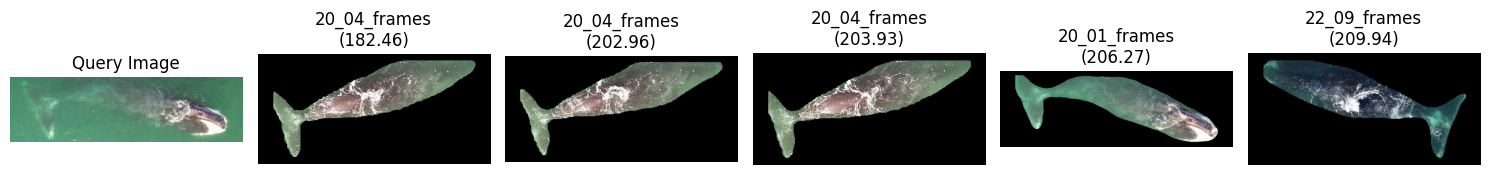


Top 5 similar classes:
- 20_04_frames (distance: 182.46)
- 20_01_frames (distance: 206.27)
- 22_09_frames (distance: 209.94)


In [ ]:
test_image_path = "/content/crop_DJI_0001_1.jpg"
if os.path.exists(test_image_path):
    search_result = search_similar_images(test_image_path, data)
    if search_result:
        show_results(search_result)

        # Вывод топ-5 классов
        print("\nTop 5 similar classes:")
        seen_classes = set()
        for res in search_result['results']:
            if res['class'] not in seen_classes:
                print(f"- {res['class']} (distance: {res['distance']:.2f})")
                seen_classes.add(res['class'])
                if len(seen_classes) == 5:
                    break
else:
    print(f"Test image {test_image_path} not found")

# Отсюда идут модули по обучению

In [ ]:
!pip install pytorch_metric_learning

In [ ]:
import os
import random
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data.sampler import Sampler
import timm
import torch.nn as nn
from pytorch_metric_learning import losses, miners
from tqdm.auto import tqdm

In [ ]:
transform_aggressive = A.Compose([
    A.RandomRotate90(p=0.6),
    #A.HorizontalFlip(p=0.6),
    #A.VerticalFlip(p=0.2),
    A.Resize(224, 224),
    A.CoarseDropout(max_holes=5, max_height=20, max_width=20, p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

transform_moderate = A.Compose([
    A.RandomRotate90(p=0.3),
    #A.HorizontalFlip(p=0.3),
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

transform_basic = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

<ipython-input-6-fcb65b63b755>:6: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=5, max_height=20, max_width=20, p=0.3),


In [ ]:
class BalancedDataGenerator(Dataset):
    def __init__(self, dataset, class_counts, max_count, transform_aggressive, transform_moderate, transform_basic):
        self.dataset = dataset
        self.class_counts = class_counts
        self.max_count = max_count
        self.transform_aggressive = transform_aggressive
        self.transform_moderate = transform_moderate
        self.transform_basic = transform_basic

        self.class_to_images = defaultdict(list)
        for img_path, label in dataset.imgs:
            self.class_to_images[label].append(img_path)

    def __len__(self):
        return self.max_count * len(self.class_counts)

    def __getitem__(self, idx):
        class_idx = idx // self.max_count
        image_idx = idx % self.max_count

        label = list(self.class_counts.keys())[class_idx]
        images = self.class_to_images[label]

        if image_idx >= len(images):
            img_path = random.choice(images)
            image = Image.open(img_path).convert('RGB')
            if self.class_counts[label] < 0.25 * self.max_count:
                transform = self.transform_aggressive
            elif self.class_counts[label] < 0.75 * self.max_count:
                transform = self.transform_moderate
            else:
                transform = self.transform_basic

            image_np = np.array(image)
            augmented = transform(image=image_np)
            image = augmented['image']
        else:
            img_path = images[image_idx]
            image = Image.open(img_path).convert('RGB')
            image_np = np.array(image)
            augmented = self.transform_basic(image=image_np)
            image = augmented['image']

        return image, label

In [ ]:
train_dataset = ImageFolder(root="/content/whales_processed/train")
test_dataset = ImageFolder(root="/content/whales_processed/test")

def get_class_counts(dataset):
    counts = defaultdict(int)
    for _, label in dataset.samples:
        counts[label] += 1
    return dict(counts)

train_counts = get_class_counts(train_dataset)
test_counts = get_class_counts(test_dataset)

print("Train counts:", train_counts)
print("Test counts:", test_counts)

Train counts: {0: 326, 1: 275, 2: 1098, 3: 101, 4: 265, 5: 448, 6: 848, 7: 487, 8: 343, 9: 116, 10: 53, 11: 278, 12: 92, 13: 99, 14: 113}
Test counts: {0: 62, 1: 53, 2: 217, 3: 23, 4: 37, 5: 95, 6: 96, 7: 100, 8: 85, 9: 26, 10: 9, 11: 64, 12: 21, 13: 20, 14: 24}


In [ ]:
train_generator = BalancedDataGenerator(
    dataset=train_dataset,
    class_counts=train_counts,
    max_count=max(train_counts.values()),
    transform_aggressive = transform_aggressive,
    transform_moderate = transform_moderate,
    transform_basic = transform_basic
)

In [ ]:
print(max(train_counts.values()))
print(len(train_generator))
print(len(train_counts.keys()))
print(len(train_generator) / max(train_counts.values()))
#Всё верно

1098
16470
15
15.0


In [ ]:
def load_embedding_model(model_name="hf-hub:BVRA/MegaDescriptor-L-384",
                         embedding_size=512,
                         device="cuda"):
    class EmbeddingModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.backbone = timm.create_model(model_name, pretrained=True)
            self.projection = nn.Linear(self.backbone.num_features, embedding_size)

        def forward(self, x):
            features = self.backbone(x)
            embeddings = self.projection(features)
            return nn.functional.normalize(embeddings, p=2, dim=1)

    model = EmbeddingModel().to(device)
    return model

In [ ]:
def train_model(model, train_loader, epochs=10, lr=1e-4, device="cuda"):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_func = losses.TripletMarginLoss(margin=0.2)
    miner = miners.TripletMarginMiner(margin=0.1)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        skipped_batches = 0

        batch_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for images, labels in batch_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            embeddings = model(images)

            triplets = miner(embeddings, labels)

            if isinstance(triplets, tuple) and len(triplets) > 0 and len(triplets[0]) == 0:
                skipped_batches += 1
                batch_bar.set_postfix(loss="skip (no triplets)", skipped=skipped_batches)
                continue

            loss = loss_func(embeddings, labels, triplets)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            batch_bar.set_postfix(
                loss=loss.item(),
                avg_loss=total_loss/(batch_bar.n + 1 - skipped_batches),
                skipped=skipped_batches
            )

        batch_bar.close()

        avg_loss = total_loss / (len(train_loader) - skipped_batches) if (len(train_loader) - skipped_batches) > 0 else 0
        print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f} | Skipped: {skipped_batches}")

    return model

In [ ]:
train_loader = DataLoader(
    train_generator,
    batch_size=7,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

In [ ]:
model = load_embedding_model(
        model_name="hf-hub:BVRA/MegaDescriptor-S-224",
        embedding_size=128,
        device="cuda"
    )

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/290M [00:00<?, ?B/s]

In [ ]:
model.load_state_dict(torch.load('/content/weights_model.pth', weights_only=True))

<All keys matched successfully>

In [ ]:
model = train_model(model=model, train_loader=train_loader, epochs=6, device="cuda")

Epoch 1/6:   0%|          | 0/2353 [00:00<?, ?it/s]

3 (tensor([0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
        6, 6, 6], device='cuda:0'), tensor([3, 3, 3, 4, 4, 4, 4, 0, 0, 0, 0, 4, 4, 4, 0, 0, 0, 0, 3, 3, 3, 6, 6, 6,
        5, 5, 5], device='cuda:0'), tensor([2, 5, 6, 1, 2, 5, 6, 1, 2, 5, 6, 1, 5, 6, 1, 2, 5, 6, 1, 5, 6, 1, 3, 4,
        1, 3, 4], device='cuda:0'))
tensor([ 6, 11,  0,  6,  6, 10, 10], device='cuda:0')
tensor(0.2972, device='cuda:0', grad_fn=<MeanBackward0>)
3 (tensor([4, 4, 4, 4, 5, 5, 5, 5], device='cuda:0'), tensor([5, 5, 5, 5, 4, 4, 4, 4], device='cuda:0'), tensor([0, 1, 2, 3, 0, 1, 2, 3], device='cuda:0'))
tensor([ 8,  5,  0, 11,  4,  4, 11], device='cuda:0')
tensor(0.1744, device='cuda:0', grad_fn=<MeanBackward0>)
3 (tensor([1, 6], device='cuda:0'), tensor([6, 1], device='cuda:0'), tensor([0, 0], device='cuda:0'))
tensor([12,  4,  1,  0,  6,  9,  4], device='cuda:0')
tensor(0.2324, device='cuda:0', grad_fn=<MeanBackward0>)
3 (tensor([2, 3], device='cuda:0'), tensor([3, 2], device=

Обработка train: 0it [00:00, ?it/s]

Обработка 20_25_frames:   0%|          | 0/401 [00:00<?, ?it/s]

Обработка 20_22_frames:   0%|          | 0/978 [00:00<?, ?it/s]

Обработка 20_19_frames:   0%|          | 0/601 [00:00<?, ?it/s]

Обработка 20_11_frames:   0%|          | 0/280 [00:00<?, ?it/s]

Обработка 20_34_frames:   0%|          | 0/193 [00:00<?, ?it/s]

Обработка 21_86_frames:   0%|          | 0/163 [00:00<?, ?it/s]

Обработка 21_06_frames:   0%|          | 0/51 [00:00<?, ?it/s]

Обработка 20_56_frames:   0%|          | 0/548 [00:00<?, ?it/s]

Обработка 20_48_frames:   0%|          | 0/406 [00:00<?, ?it/s]

Обработка 21_02_frames:   0%|          | 0/232 [00:00<?, ?it/s]

Оценка модели: 0it [00:00, ?it/s]

Оценка модели:   0%|          | 0/80 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/192 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/74 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/48 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/47 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/23 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/11 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/126 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/58 [00:00<?, ?it/s]

Оценка модели:   0%|          | 0/54 [00:00<?, ?it/s]


Классификационные метрики (top-1):
              precision    recall  f1-score   support

20_11_frames       1.00      0.67      0.80        48
20_19_frames       0.06      0.05      0.06        74
20_22_frames       0.95      0.77      0.85       192
20_25_frames       0.55      0.97      0.70        80
20_34_frames       0.00      0.00      0.00        47
20_48_frames       1.00      0.91      0.95        58
20_56_frames       0.94      1.00      0.97       126
21_02_frames       0.79      0.70      0.75        54
21_06_frames       0.19      1.00      0.31        11
21_86_frames       1.00      1.00      1.00        23

    accuracy                           0.72       713
   macro avg       0.65      0.71      0.64       713
weighted avg       0.73      0.72      0.71       713


Метрики поиска:
Recall@1: 71.81%
Recall@3: 74.61%
Recall@5: 75.46%


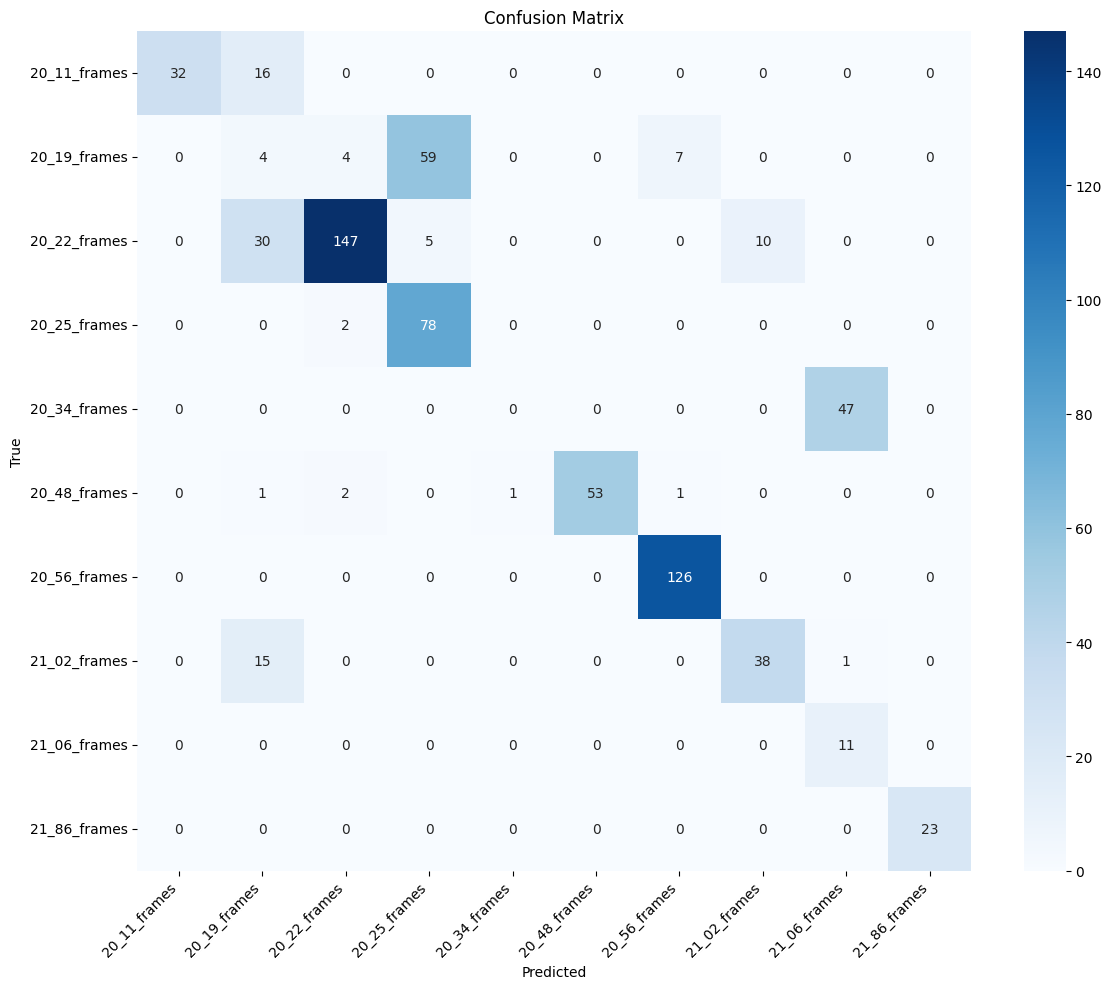

{'precision': 0.7332360342710382, 'recall': 0.7180925666199158, 'f1': 0.7092875743549175, 'accuracy': 0.7180925666199158, 'recall@k': {1: 0.7180925666199158, 3: 0.7461430575035063, 5: 0.7545582047685835}}


In [ ]:
DATA_PATH = "whales_processed"
IMAGE_SIZE = 224

transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_index, train_paths = build_faiss_index(os.path.join(DATA_PATH, "train"))

metrics = evaluate_model(
    test_folder=os.path.join(DATA_PATH, "test"),
    index=train_index,
    paths=train_paths,
    k_values=(1,3,5)
)
print(metrics)

### Тест пайплайна


In [ ]:
!unzip /content/whales_pipeline.zip

Archive:  /content/whales_pipeline.zip
   creating: whales_pipeline/
   creating: whales_pipeline/config/
  inflating: whales_pipeline/config/data_preparation_config.yaml  
  inflating: whales_pipeline/config/train_modules_config.yaml  
   creating: whales_pipeline/pipeline/
  inflating: whales_pipeline/pipeline/data_preparation.py  
  inflating: whales_pipeline/pipeline/run.py  
  inflating: whales_pipeline/pipeline/train_modules.py  
  inflating: whales_pipeline/pipeline/validation.py  


In [ ]:
%cd /content/whales_pipeline/pipeline

/content/whales_pipeline/pipeline


In [ ]:
!ls

data_preparation.py  run.py  train_modules.py  validation.py


In [ ]:
!python run.py

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
hello hello, hope u feeling good
Приступаю к подготовке данных
Загрузка Whale ReId 2.7z: 100% 7.62G/7.62G [15:36<00:00, 8.14MB/s]
100% 102/102 [15:22<00:00,  9.05s/it]

Кит             Train фото Test фото  Train %    Test %     Даты (train/test)
----------------------------------------------------------------------
21_16_frames    32         5          86.5      % 13.5      % 1/2       
20_54_frames    475        112        80.9      % 19.1      % 8/3       
20_10_frames    435        116        78.9      % 21.1      % 2/1       
20_34_frames    193        47         80.4      % 19.6      % 3/5       
21_38_frames    140        34         80.5      % 19.5      % 7/2   

### Работа над новым вариантом разбиения на треин/тест

In [2]:
import os
import shutil
import cv2
import numpy as np

def apply_alpha_mask(jpg_path, png_path, output_path):
    """Улучшенная обработка масок с проверкой формата"""
    img = cv2.imread(jpg_path)
    mask = cv2.imread(png_path, cv2.IMREAD_UNCHANGED)

    if mask is None:
        shutil.copy2(jpg_path, output_path)
        return

    # Обработка разных форматов масок
    if len(mask.shape) == 2:  # Градации серого (1 канал)
        alpha = mask
    elif mask.shape[2] == 4:  # RGBA (4 канала)
        alpha = mask[:, :, 3]
    elif mask.shape[2] == 3:  # RGB (3 канала)
        alpha = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
        _, alpha = cv2.threshold(alpha, 0, 255, cv2.THRESH_BINARY)
    else:
        shutil.copy2(jpg_path, output_path)
        return

    # Накладываем маску
    img = cv2.bitwise_and(img, img, mask=alpha)
    cv2.imwrite(output_path, img)

def process_whales(input_dir, output_dir, class_names, use_masks):
    """Обработка с гарантией, что все подпапки класса - crops"""
    os.makedirs(output_dir, exist_ok=True)

    # Создаем папки train и test в output_dir
    train_dir = os.path.join(output_dir, 'train')
    test_dir = os.path.join(output_dir, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Получаем список всех папок во входной директории
    all_folders = [f for f in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, f))]

    # Обрабатываем папки, не входящие в class_names (идут в train)
    for folder in all_folders:
        if folder not in class_names:
            class_path = os.path.join(input_dir, folder)
            output_class_path = os.path.join(train_dir, folder)
            os.makedirs(output_class_path, exist_ok=True)

            # Все элементы в папке класса - crops-папки (по условию)
            for crop_folder in os.listdir(class_path):
                crop_path = os.path.join(class_path, crop_folder)
                if not os.path.isdir(crop_path):
                    continue  # Пропускаем файлы (если есть)

                output_crop_path = os.path.join(output_class_path, crop_folder)
                os.makedirs(output_crop_path, exist_ok=True)

                # Обрабатываем файлы в crops-папке
                for file in os.listdir(crop_path):
                    file_lower = file.lower()
                    src_path = os.path.join(crop_path, file)

                    if file_lower.endswith('.jpg'):
                        dest_path = os.path.join(output_crop_path, file)

                        if use_masks:
                            # Ищем маску с тем же именем
                            mask_path = os.path.join(crop_path, os.path.splitext(file)[0] + '.png')
                            if os.path.exists(mask_path):
                                apply_alpha_mask(src_path, mask_path, dest_path)
                            else:
                                shutil.copy2(src_path, dest_path)
                        else:
                            shutil.copy2(src_path, dest_path)

                    elif file_lower.endswith('.png') and not use_masks:
                        continue  # Пропускаем маски в этом режиме

    # Обрабатываем папки из class_names (идут в test)
    for class_name in class_names:
        class_path = os.path.join(input_dir, class_name)
        if not os.path.exists(class_path):
            print(f"⚠️ Класс {class_name} не найден, пропускаем")
            continue

        output_class_path = os.path.join(test_dir, class_name)
        os.makedirs(output_class_path, exist_ok=True)

        # Все элементы в папке класса - crops-папки (по условию)
        for crop_folder in os.listdir(class_path):
            crop_path = os.path.join(class_path, crop_folder)
            if not os.path.isdir(crop_path):
                continue  # Пропускаем файлы (если есть)

            output_crop_path = os.path.join(output_class_path, crop_folder)
            os.makedirs(output_crop_path, exist_ok=True)

            # Обрабатываем файлы в crops-папке
            for file in os.listdir(crop_path):
                file_lower = file.lower()
                src_path = os.path.join(crop_path, file)

                if file_lower.endswith('.jpg'):
                    dest_path = os.path.join(output_crop_path, file)

                    if use_masks:
                        # Ищем маску с тем же именем
                        mask_path = os.path.join(crop_path, os.path.splitext(file)[0] + '.png')
                        if os.path.exists(mask_path):
                            apply_alpha_mask(src_path, mask_path, dest_path)
                        else:
                            shutil.copy2(src_path, dest_path)
                    else:
                        shutil.copy2(src_path, dest_path)

                elif file_lower.endswith('.png') and not use_masks:
                    continue  # Пропускаем маски в этом режиме

In [12]:
input_dir = '/content/Whales/Whale ReId 2'
output_dir = '/content/whales_chopped_clean'

class_folders = ['20_05_frames', '21_23_frames', '20_45_frames', '20_67_frames', '20_10_frames', '21_05_frames', '20_19_frames',
                 '21_67_frames', '20_16_frames', '21_41_frames', '21_06_frames', '21_09_frames', '20_02_frames', '21_02_frames']

use_masks = False

process_whales(input_dir, output_dir, class_folders, use_masks)
print(f"Обработка завершена. Результат сохранен в {output_dir}")

Обработка завершена. Результат сохранен в /content/whales_chopped_clean


In [13]:
def set_transforms(image_size):
    return transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomRotation(degrees=(0, 180)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    return transform_moderate

In [14]:
import torch
import torch.nn as nn
import timm
import yaml
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import os
from torch import optim
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset

In [5]:
from PIL import Image

class FixedSizeImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = ImageFolder(root=root)
        self.transform = transform
        self.classes = self.dataset.classes
        self.class_to_idx = self.dataset.class_to_idx

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        # Конвертируем в RGB на случай grayscale изображений
        if img.mode != 'RGB':
            img = img.convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

In [6]:
!pip install pytorch_metric_learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.9/125.9 kB 5.7 MB/s eta 0:00:00


In [7]:
from pytorch_metric_learning import losses, miners

In [22]:
def load_compressed_embedding_model(model_name="hf-hub:BVRA/MegaDescriptor-S-224",
                         embedding_size=512,
                         device="cuda"):
    class EmbeddingModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.backbone = timm.create_model(model_name, pretrained=True)
            self.projection = nn.Linear(self.backbone.num_features, embedding_size)

        def forward(self, x):
            features = self.backbone(x)
            embeddings = self.projection(features)
            return nn.functional.normalize(embeddings, p=2, dim=1)

    model = EmbeddingModel().to(device)
    return model


def load_base_embedding_model(model_name="hf-hub:BVRA/MegaDescriptor-S-224",
                         device="cuda"):

    model = timm.create_model(model_name, pretrained=True).to(device)
    return model


def prepare_training_modules(yaml_path):
    with open(yaml_path, 'r') as file:
        config = yaml.safe_load(file)
    config = config['prepare_modules']

    # Убедимся, что shape - это кортеж (height, width)
    if isinstance(config['shape'], int):
        image_size = (config['shape'], config['shape'])
    else:
        image_size = tuple(config['shape'])

    transform = set_transforms(image_size)

    train_dataset = FixedSizeImageFolder(
        root="/content/whales_chopped_clean/train",
        transform=transform
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    if config['compress_model']:
        model = load_compressed_embedding_model(
            model_name=config['model_name'],
            embedding_size=config['compressed_shape'],
            device="cuda"
        )
    else:
        model = load_base_embedding_model(
            model_name=config['model_name'],
            device="cuda"
        )

    return train_loader, model, image_size


class ArcFaceLoss(nn.Module):
    def __init__(self, s=30.0, m=0.5, num_classes=None, embedding_size=512):
        """
        ArcFace Loss (Additive Angular Margin Loss)

        Параметры:
        - s: масштаб выходов (scale), обычно 30-64
        - m: угловой запас (margin), обычно 0.3-0.5
        - num_classes: количество классов в задаче
        - embedding_size: размер эмбеддингов
        """
        super().__init__()
        self.s = s
        self.m = m
        self.num_classes = num_classes
        self.embedding_size = embedding_size

        # Веса для классификации
        self.W = nn.Parameter(torch.Tensor(embedding_size, num_classes))
        nn.init.xavier_normal_(self.W)

    def forward(self, embeddings, labels):
        """
        Вход:
        - embeddings: нормализованные эмбеддинги (batch_size, embedding_size)
        - labels: метки классов (batch_size)
        """
        # Нормализуем веса и эмбеддинги
        W_norm = F.normalize(self.W, p=2, dim=0)
        embeddings_norm = F.normalize(embeddings, p=2, dim=1)

        # Косинус угла между эмбеддингами и весами (логиты)
        cos_theta = torch.mm(embeddings_norm, W_norm)  # (batch_size, num_classes)

        # Для правильных классов добавляем маргин
        theta = torch.acos(torch.clamp(cos_theta, -1.0 + 1e-7, 1.0 - 1e-7))
        one_hot = F.one_hot(labels, num_classes=self.num_classes)
        cos_theta_m = torch.cos(theta + self.m * one_hot)

        # Масштабируем и вычисляем loss
        logits = self.s * (one_hot * cos_theta_m + (1 - one_hot) * cos_theta)
        loss = F.cross_entropy(logits, labels)

        return loss


def train_model(model, train_loader, shape, epochs=10, lr=1e-4, device="cuda", weights_dir="best_model", eval_step=1):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    num_classes = len(train_loader.dataset.classes)
    embedding_size = 768  # или config['compressed_shape'], если используется сжатие
    #loss_func = ArcFaceLoss(s=55.0, m=0.35, num_classes=num_classes, embedding_size=embedding_size).to(device) #for arcface
    loss_func = losses.TripletMarginLoss(margin=0.45) #for triplet
    miner = miners.TripletMarginMiner(margin=0.45, type_of_triplets='semihard') #for triplet
    os.makedirs(weights_dir, exist_ok=True)
    best_loss = float('inf')
    print('Тест базовой модели до влияния первой эпохи:')
    evaluate_model(model, (224,224), '/content/whales_chopped_clean/test', k_values=(1, 5, 10))
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        skipped_batches = 0

        batch_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for images, labels in batch_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            embeddings = model(images)
            triplets = miner(embeddings, labels) #for triplet
            #loss = loss_func(embeddings, labels)  #for arcface
            loss = loss_func(embeddings, labels, triplets) #for triplet
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            batch_bar.set_postfix(
                loss=loss.item(),
                avg_loss=total_loss/(batch_bar.n + 1),
                skipped=skipped_batches
            )

        batch_bar.close()

        avg_loss = total_loss / len(train_loader) if len(train_loader) > 0 else 0
        print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), os.path.join(weights_dir, "best_weights.pth"))
            print(f"New best weights saved with loss {best_loss:.4f}")

        if (epoch+1) % eval_step == 0:
            print('start validation')
            evaluate_model(model, (224,224), '/content/whales_chopped_clean/test', k_values=(1, 3, 5))

    model.load_state_dict(torch.load(os.path.join(weights_dir, "best_weights.pth")))

    return model

In [16]:
import numpy as np
from tqdm import tqdm
import faiss
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import torch
from torchvision import transforms
import os
from collections import defaultdict

def evaluate_model(model, shape, data_root="../whales_processed/val",
                 k_values=(1, 3, 5), device="cuda", debug_samples=3):
    """
    Модифицированная функция оценки с:
    - Корректным расчетом Precision и Recall для топ-k
    - Метриками на уровне классов (агрегирование по классам)
    - Поддержкой мультиклассовой оценки
    """
    # 1. Трансформации (аналогичные обучающим)
    transform = transforms.Compose([
        transforms.Resize(shape),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # 2. Загрузка метаданных
    def load_data(data_root):
        metadata = []
        class_to_idx = {}
        class_samples = defaultdict(int)  # Для подсчета количества примеров в каждом классе

        for class_name in os.listdir(data_root):
            if class_name not in class_to_idx:
                class_to_idx[class_name] = len(class_to_idx)

            class_path = os.path.join(data_root, class_name)
            for crop_folder in os.listdir(class_path):
                crop_path = os.path.join(class_path, crop_folder)
                for file in os.listdir(crop_path):
                    if file.lower().endswith(('.jpg', '.png')):
                        metadata.append({
                            'path': os.path.join(crop_path, file),
                            'class': class_name,
                            'class_idx': class_to_idx[class_name],
                            'crop': crop_folder
                        })
                        class_samples[class_name] += 1
        return metadata, class_to_idx, class_samples

    metadata, class_to_idx, class_samples = load_data(data_root)
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    num_classes = len(class_to_idx)

    # 3. Извлечение эмбеддингов
    embeddings = []
    model.eval()
    with torch.no_grad():
        for item in tqdm(metadata, desc='Extracting embeddings'):
            img = Image.open(item['path']).convert('RGB')
            tensor = transform(img).unsqueeze(0).to(device)
            embedding = model(tensor).cpu().numpy().flatten()
            embeddings.append(embedding)

    embeddings = np.array(embeddings).astype('float32')
    class_indices = np.array([item['class_idx'] for item in metadata])

    # 4. Создание FAISS индекса
    dimension = embeddings[0].shape[0]
    index = faiss.IndexFlatL2(dimension)
    index.add(embeddings)

    # 5. Подготовка структур для хранения результатов
    results = {k: {'correct': 0, 'total': 0} for k in k_values}
    class_results = {k: defaultdict(lambda: {'correct': 0, 'total': 0}) for k in k_values}

    # Для расчета precision/recall по классам
    y_true_all = {k: [] for k in k_values}
    y_pred_all = {k: [] for k in k_values}

    for i, item in tqdm(enumerate(metadata), desc='Evaluating'):
        query_embedding = embeddings[i]
        query_class = item['class_idx']
        query_crop = item['crop']
        query_path = item['path']

        # Фильтрация по crop
        valid_indices = [
            j for j, m in enumerate(metadata)
            if m['crop'] != query_crop
        ]

        # Поиск соседей
        distances, indices = index.search(query_embedding.reshape(1, -1), max(k_values)*100)

        # Фильтрация индексов
        filtered_indices = [idx for idx in indices[0] if idx in valid_indices]

        for k in k_values:
            if len(filtered_indices) < k:
                continue

            top_k_indices = filtered_indices[:k]
            top_k_classes = [metadata[idx]['class_idx'] for idx in top_k_indices]

            # Для метрик на уровне изображений
            is_correct = int(query_class in top_k_classes)
            predicted_class = top_k_classes[0]

            results[k]['total'] += 1
            results[k]['correct'] += is_correct

            # Для метрик на уровне классов
            class_name = idx_to_class[query_class]
            class_results[k][class_name]['total'] += 1
            class_results[k][class_name]['correct'] += is_correct

            # Для расчета precision/recall
            y_true_all[k].append(query_class)
            y_pred_all[k].append(predicted_class)

    # 6. Расчет метрик
    metrics = {}
    class_metrics = {k: {} for k in k_values}

    for k in k_values:
        if not y_true_all[k]:
            continue

        # Метрики на уровне изображений
        acc = results[k]['correct'] / results[k]['total'] if results[k]['total'] > 0 else 0
        precision = precision_score(y_true_all[k], y_pred_all[k], average='macro', zero_division=0)
        recall = recall_score(y_true_all[k], y_pred_all[k], average='macro', zero_division=0)
        f1 = f1_score(y_true_all[k], y_pred_all[k], average='macro', zero_division=0)

        metrics[k] = {
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'samples': results[k]['total']
        }

        # Метрики на уровне классов
        for class_name in class_results[k]:
            class_total = class_results[k][class_name]['total']
            class_correct = class_results[k][class_name]['correct']

            class_metrics[k][class_name] = {
                'accuracy': class_correct / class_total if class_total > 0 else 0,
                'support': class_total
            }

        # Средняя accuracy по классам (а не по изображениям)
        class_acc = np.mean([v['accuracy'] for v in class_metrics[k].values()])
        metrics[k]['class_avg_accuracy'] = class_acc

    # 7. Вывод результатов
    print("\n=== Результаты валидации ===")
    for k in sorted(metrics.keys()):
        print(f"\nTop-{k} Metrics:")
        print(f"Accuracy (image level): {metrics[k]['accuracy']:.4f}")
        print(f"Class Avg Accuracy: {metrics[k]['class_avg_accuracy']:.4f}")
        print(f"Precision: {metrics[k]['precision']:.4f}")
        print(f"Recall: {metrics[k]['recall']:.4f}")
        print(f"F1-score: {metrics[k]['f1_score']:.4f}")
        print(f"Samples: {metrics[k]['samples']}")

    return {
        'metrics': metrics,
        'class_metrics': class_metrics,
        'class_samples': dict(class_samples)
    }

In [17]:
def flatten_directory_structure(root_dir):
    for split in ["train"]:
        split_path = os.path.join(root_dir, split)
        if not os.path.exists(split_path):
            continue

        for whale in tqdm(os.listdir(split_path), desc=f"Processing {split}"):
            whale_path = os.path.join(split_path, whale)

            for root, dirs, files in os.walk(whale_path):
                for file in files:
                    if file.lower().endswith(('.jpg')):
                        src_path = os.path.join(root, file)

                        date_folder = os.path.basename(root)
                        new_filename = f"{date_folder}_{file}"

                        dest_path = os.path.join(whale_path, new_filename)

                        shutil.move(src_path, dest_path)

            for root, dirs, files in os.walk(whale_path, topdown=False):
                for dir in dirs:
                    dir_path = os.path.join(root, dir)
                    if not os.listdir(dir_path):
                        os.rmdir(dir_path)

flatten_directory_structure("/content/whales_chopped_clean")

Processing train: 100%|██████████| 88/88 [00:00<00:00, 120.11it/s]


In [23]:
train_loader, model, shape = prepare_training_modules('/content/train_modules_config.yaml')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.92G [00:00<?, ?B/s]

In [24]:
with open('/content/train_modules_config.yaml', 'r') as file:
  config = yaml.safe_load(file)
config = config['trainer_config']

model = train_model(model, train_loader, shape, epochs = config['num_epochs'], lr = config['lr'], eval_step = config['eval_step'])

Тест базовой модели до влияния первой эпохи:


Extracting embeddings: 100%|██████████| 5177/5177 [03:59<00:00, 21.64it/s]
Evaluating: 5177it [10:04,  8.57it/s]



=== Результаты валидации ===

Top-1 Metrics:
Accuracy (image level): 0.6170
Class Avg Accuracy: 0.6744
Precision: 0.6390
Recall: 0.6744
F1-score: 0.6448
Samples: 5177

Top-5 Metrics:
Accuracy (image level): 0.6772
Class Avg Accuracy: 0.7158
Precision: 0.6390
Recall: 0.6744
F1-score: 0.6448
Samples: 5177

Top-10 Metrics:
Accuracy (image level): 0.7048
Class Avg Accuracy: 0.7344
Precision: 0.6390
Recall: 0.6744
F1-score: 0.6448
Samples: 5177


KeyboardInterrupt: 